# Prepare Data

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import sys
sys.path.append("../")
from utils.prepare_data import *
from inception_v3.build_models import *
from resnet50.build_models import *
from PIL import Image
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
X_train, y_train, X_test, y_test, attribute_list = generate_peta()

['accessoryHeadphone', 'personalLess15', 'personalLess30', 'personalLess45', 'personalLess60', 'personalLarger60', 'carryingBabyBuggy', 'carryingBackpack', 'hairBald', 'footwearBoots', 'lowerBodyCapri', 'carryingOther', 'carryingShoppingTro', 'carryingUmbrella', 'lowerBodyCasual', 'upperBodyCasual', 'personalFemale', 'carryingFolder', 'lowerBodyFormal', 'upperBodyFormal', 'accessoryHairBand', 'accessoryHat', 'lowerBodyHotPants', 'upperBodyJacket', 'lowerBodyJeans', 'accessoryKerchief', 'footwearLeatherShoes', 'upperBodyLogo', 'hairLong', 'lowerBodyLongSkirt', 'upperBodyLongSleeve', 'lowerBodyPlaid', 'lowerBodyThinStripes', 'carryingLuggageCase', 'personalMale', 'carryingMessengerBag', 'accessoryMuffler', 'accessoryNothing', 'carryingNothing', 'upperBodyNoSleeve', 'upperBodyPlaid', 'carryingPlasticBags', 'footwearSandals', 'footwearShoes', 'hairShort', 'lowerBodyShorts', 'upperBodyShortSleeve', 'lowerBodyShortSkirt', 'footwearSneakers', 'footwearStocking', 'upperBodyThinStripes', 'upper

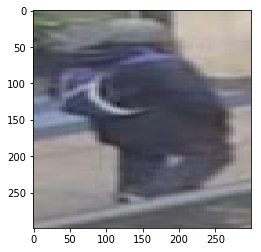

(1, 299, 299, 3)

In [3]:
def load_img(path, image_shape=(299, 299)):
    img = image.load_img(path, target_size=(image_shape[0], image_shape[1], 3))
    plt.imshow(img)
    plt.show()
    img = image.img_to_array(img)
    img = img[np.newaxis, ...]
    return img

load_img(X_train[0]).shape

# PartPool Model Summary

In [4]:
whole = [1,2,3,4,5,16,34]
hs = [0,8,20,21,25,28,36,37,44,54]
ub = [15,19,23,27,30,39,40,46,50,51,55,56,58,59,60]
lb = [10,14,18,22,24,29,31,32,45,47,53,57]
sh = [9,26,42,43,48,49]
at = [6,7,11,12,13,17,33,35,38,41,52]

titles = ["whole", "hs", "ub", "lb", "sh", "at"]

In [5]:
version = "v1"
#model = build_partpool_inception([len(whole), len(hs), len(ub), len(lb), len(sh), len(at)], version)
model = build_partpool_resnet50([len(whole), len(hs), len(ub), len(lb), len(sh), len(at)], version)

/home/anhaoran/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 305, 305, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

# Define Attention Output Model

In [6]:
#model.load_weights("../../models/PETA/PartPoolInception/v1_epoch048_valloss0.979095.hdf5", by_name=True)
model.load_weights("../../models/PETA/PartPoolResNet50/v1_epoch043_valloss0.980075.hdf5", by_name=True)

In [7]:
layer_name = ["lambda_5", "lambda_7", "lambda_9", "lambda_11", "lambda_13", "lambda_15"]
model_refined_feature = Model(inputs=model.input, outputs=[model.get_layer(layer_name[i]).output for i in range(6)])
model_refined_feature.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 305, 305, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [8]:
layer_name = "conv2d_1"
model_attention = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
model_attention.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 305, 305, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

# Plot

In [9]:
def show(idx):
    #print(X_train[idx])
    img = load_img(X_train[idx])
    img_resize = Image.fromarray(img[0].astype('uint8'))
    img_resize = img_resize.resize((10, 10),Image.ANTIALIAS)
    img_resize = image.img_to_array(img_resize)
    img_attention = model_attention.predict(img)
    img_refined_feature = model_refined_feature.predict(img)
    for i in range(len(img_refined_feature)):
        plt.subplot(4, 6, i+1)
        plt.title(titles[i])
        plt.axis('off')
        plt.imshow(img_attention[0, :, :, i])

        plt.subplot(4, 6, i+7)
        """
        att = Image.fromarray(np.sum(img_attention[i][0, :, :, :], axis=2).astype('uint8'))
        att = att.resize((299, 299),Image.ANTIALIAS)
        att = image.img_to_array(att)
        #"""
        att = cv2.applyColorMap(np.uint8(img_attention[0, :, :, i]), cv2.COLORMAP_JET)
        img_show = img_resize*0.7 + att*0.3
        img_show = Image.fromarray(np.uint8(img_show))
        plt.axis('off')
        plt.imshow(img_show)

        plt.subplot(4, 6, i+13)
        plt.axis('off')
        plt.imshow(np.sum(img_refined_feature[i][0, :, :, :], axis=2))

        #"""
        plt.subplot(4, 6, i+19)
        """
        att = Image.fromarray(np.sum(img_attention[i][0, :, :, :], axis=2).astype('uint8'))
        att = att.resize((299, 299),Image.ANTIALIAS)
        att = image.img_to_array(att)
        #"""
        att = cv2.applyColorMap(np.uint8(np.sum(img_refined_feature[i][0, :, :, :], axis=2)), cv2.COLORMAP_JET)
        img_show = img_resize*0.7 + att*0.3
        img_show = Image.fromarray(np.uint8(img_show))
        plt.axis('off')
        plt.imshow(img_show)
    plt.show()

In [10]:
def show_max(idx):
    #print(X_train[idx])
    img = load_img(X_train[idx])
    img_attention = model_attention.predict(img)
    img_refined_feature = model_refined_feature.predict(img)
    for i in range(len(img_refined_feature)):
        plt.subplot(2, 6, i+1)
        plt.title(titles[i])
        plt.axis('off')
        total = np.argmax(img_attention[0, :, :, i])
        x = total // 10 * 33
        y = total % 10 * 33
        att = np.zeros((img.shape[1], img.shape[2], 3))
        att[x:x+100, y:y+100, :] = 255
        #att = cv2.applyColorMap(np.uint8(att), cv2.COLORMAP_JET)
        img_show = img[0]*0.7 + att*0.3
        img_show = Image.fromarray(np.uint8(img_show))
        plt.imshow(img_show)

        plt.subplot(2, 6, i+7)
        plt.axis('off')
        total = np.argmax(np.sum(img_refined_feature[i][0, :, :, :]))
        x = total // 10 * 33
        y = total % 10 * 33
        att = np.zeros((img.shape[1], img.shape[2], 3))
        att[x:x+100, y:y+100, :] = 255
        #att = cv2.applyColorMap(np.uint8(att), cv2.COLORMAP_JET)
        img_show = img[0]*0.7 + att*0.3
        img_show = Image.fromarray(np.uint8(img_show))
        plt.imshow(img_show)
    plt.show()

In [11]:
def show_channel(idx, c):
    #print(X_train[idx])
    img = load_img(X_train[idx])
    img_resize = Image.fromarray(img[0].astype('uint8'))
    img_resize = img_resize.resize((10, 10),Image.ANTIALIAS)
    img_resize = image.img_to_array(img_resize)
    img_attention = model_attention.predict(img)
    img_refined_feature = model_refined_feature.predict(img)
    for i in range(len(img_refined_feature)):
        plt.subplot(4, 6, i+1)
        plt.title(titles[i])
        plt.axis('off')
        plt.imshow(img_attention[0, :, :, i])

        plt.subplot(4, 6, i+7)
        """
        att = Image.fromarray(np.sum(img_attention[i][0, :, :, :], axis=2).astype('uint8'))
        att = att.resize((299, 299),Image.ANTIALIAS)
        att = image.img_to_array(att)
        #"""
        att = cv2.applyColorMap(np.uint8(img_attention[0, :, :, i]), cv2.COLORMAP_JET)
        img_show = img_resize*0.7 + att*0.3
        img_show = Image.fromarray(np.uint8(img_show))
        plt.axis('off')
        plt.imshow(img_show)

        plt.subplot(4, 6, i+13)
        plt.axis('off')
        plt.imshow(img_refined_feature[i][0, :, :, c])

        #"""
        plt.subplot(4, 6, i+19)
        """
        att = Image.fromarray(np.sum(img_attention[i][0, :, :, :], axis=2).astype('uint8'))
        att = att.resize((299, 299),Image.ANTIALIAS)
        att = image.img_to_array(att)
        #"""
        att = cv2.applyColorMap(np.uint8(img_refined_feature[i][0, :, :, c]), cv2.COLORMAP_JET)
        img_show = img_resize*0.7 + att*0.3
        img_show = Image.fromarray(np.uint8(img_show))
        plt.axis('off')
        plt.imshow(img_show)
    plt.show()

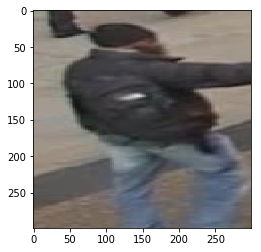

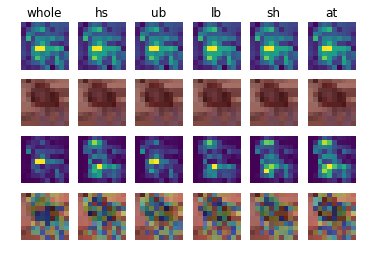

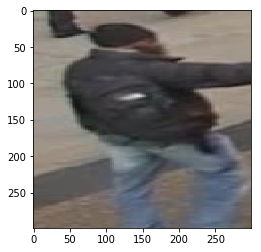

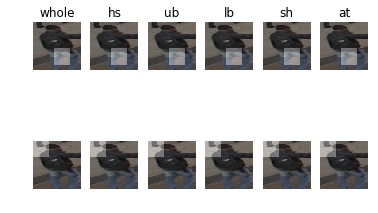

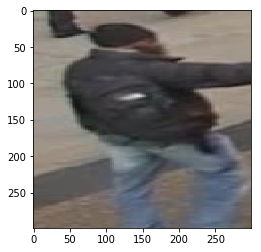

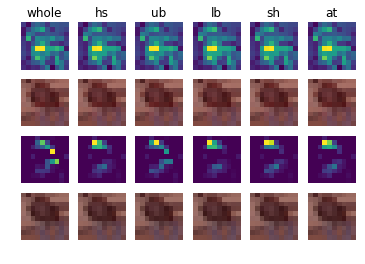

In [25]:
i = 13
show(i)
show_max(i)
show_channel(i, 0)

sample | part_name | channel_num
- | - | -
0 | whole |
0 | hs |
0 | ub |
0 | lb |
0 | sh |
0 | at | 20,28

In [123]:
best_samples = [0]